In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

In [2]:
# Load the dataset into a DataFrame and save in a variable
df0 = pd.read_csv("datasets/listings.csv")

In [3]:
# Display the first 10 rows of the data
df0.head(10)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,40824219,https://www.airbnb.com/rooms/40824219,20251001171547,2025-10-02,city scrape,Room close to Manhattan for FEMALE guests,This cozy spacious room includes a twin size b...,Sunnyside is a safe residental area. <br />The...,https://a0.muscache.com/pictures/hosting/Hosti...,317540555,https://www.airbnb.com/users/show/317540555,Sevil,2019-12-14,NaN,NaN,within a few hours,100%,54%,t,https://a0.muscache.com/im/pictures/user/771f9...,https://a0.muscache.com/im/pictures/user/771f9...,Sunnyside,3.0,3.0,"['email', 'phone']",t,t,Neighborhood highlights,Sunnyside,Queens,40.746980,-73.917630,Private room in townhouse,Private room,1,1.0,1 shared bath,1.0,1.0,"[""Extra pillows and blankets"", ""Dedicated work...",$66.00,30,365,30.0,30.0,365.0,365.0,30.0,365.0,NaN,t,16,46,76,77,2025-10-02,16,2,0,77,0,120,7920.0,2019-12-25,2025-08-06,4.81,4.81,4.88,4.81,4.88,4.94,4.69,NaN,f,3,0,3,0,0.23
1,40833186,https://www.airbnb.com/rooms/40833186,20251001171547,2025-10-02,previous scrape,Soho LES East village private room downtown,NaN,NaN,https://a0.muscache.com/pictures/1f093bbc-936c...,68718914,https://www.airbnb.com/users/show/68718914,Patricio,2016-04-24,NaN,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/0b4f9...,https://a0.muscache.com/im/pictures/user/0b4f9...,NaN,1.0,1.0,['phone'],t,t,NaN,Nolita,Manhattan,40.723140,-73.993230,Private room in serviced apartment,Private room,2,NaN,1 shared bath,1.0,NaN,"[""Hot water"", ""Air conditioning"", ""Wifi"", ""TV""...",NaN,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,0,0,0,0,2025-10-02,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,0,1,0,NaN
2,40837137,https://www.airbnb.com/rooms/40837137,20251001171547,2025-10-02,previous scrape,Sunset Park - Quiet and close to subway!,"Cozy, lovely bedroom with a comfortable full s...",the sunset park of Brooklyn,https://a0.muscache.com/pictures/01c4e91e-4012...,317770098,https://www.airbnb.com/users/show/317770098,Xuan,2019-12-15,"New York, United States",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/2c4b1...,https://a0.muscache.com/im/pictures/user/2c4b1...,Sunset Park,1.0,1.0,"['email', 'phone']",t,t,Neighborhood highlights,Sunset Park,Brooklyn,40.646070,-74.005520,Private room in home,Private room,1,NaN,1 shared bath,NaN,NaN,"[""Smoke alarm"", ""Kitchen"", ""Hair dryer"", ""Wifi...",NaN,30,180,30.0,30.0,180.0,180.0,30.0,180.0,NaN,NaN,0,0,0,0,2025-10-02,1,0,0,0,0,0,NaN,2020-01-19,2020-01-19,5.00,5.00,4.00,5.00,5.00,5.00,5.00,NaN,f,1,0,1,0,0.01
3,40838018,https://www.airbnb.com/rooms/40838018,20251001171547,2025-10-02,previous scrape,C

In [4]:
# Gather basic information about the dataset
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36111 entries, 0 to 36110
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            36111 non-null  int64  
 1   listing_url                                   36111 non-null  object 
 2   scrape_id                                     36111 non-null  int64  
 3   last_scraped                                  36111 non-null  object 
 4   source                                        36111 non-null  object 
 5   name                                          36109 non-null  object 
 6   description                                   35153 non-null  object 
 7   neighborhood_overview                         18704 non-null  object 
 8   picture_url                                   36111 non-null  object 
 9   host_id                                       36111 non-null 

In [5]:
# Gather descriptive statistics about the data
df0.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.611100e+04,3.611100e+04,3.611100e+04,34944.000000,34944.000000,36111.000000,36111.000000,36111.000000,21700.000000,30162.000000,21643.000000,36111.000000,3.611100e+04,36099.000000,36099.000000,3.609900e+04,3.609900e+04,36111.000000,3.611100e+04,0.0,36111.000000,36111.000000,36111.000000,36111.000000,36111.000000,36111.000000,36111.000000,36111.000000,36111.000000,36111.000000,2.132800e+04,24923.000000,24913.000000,24922.000000,24909.000000,24917.000000,24907.000000,24907.000000,36111.000000,36111.000000,36111.000000,36111.000000,24923.000000
mean,4.667906e+17,2.025100e+13,1.756195e+08,112.264652,194.007068,40.728253,-73.947350,2.733239,1.192788,1.386016,1.621587,28.610091,6.003553e+04,28.403335,38.708274,2.980906e+05,9.524952e+05,29.459694,6.986474e+05,NaN,8.704578,21.359198,35.372518,162.188724,27.321232,3.983606,0.300573,35.873446,3.537648,46.951594,1.809287e+04,4.722113,4.762297,4.655356,4.833791,4.821406,4.743204,4.634118,67.455152,48.661793,17.957824,0.052532,0.821178
std,5.448721e+17,1.441426e+00,1.945624e+08,592.417347,900.407345,0.056269,0.054995,1.866400,0.548018,0.944931,1.211541,29.166476,1.130082e+07,28.933871,63.420625,2.527220e+07,4.520140e+07,33.684524,3.579217e+07,NaN,12.106346,24.537592,36.932982,147.262625,70.308684,19.468284,1.448168,37.367742,18.974885,85.004647,1.543908e+05,0.463000,0.447870,0.510746,0.384702,0.425933,0.399600,0.504016,215.678813,204.537592,79.015677,0.775728,1.916104
min,2.595000e+03,2.025100e+13,1.678000e+03,1.000000,1.000000,40.500366,-74.251907,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.159416e+07,2.025100e+13,1.795864e+07,1.000000,1.000000,40.688260,-73.983560,2.000000,1.000000,1.000000,1.000000,30.000000,1.500000e+02,30.000000,30.000000,3.000000e+02,3.650000e+02,30.000000,3.650000e+02,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,4.650000,4.710000,4.540000,4.820000,4.820000,4.660000,4.520000,1.000000,0.000000,0.000000,0.000000,0.070000
50%,5.095308e+07,2.025100e+13,8.832602e+07,2.000000,3.000000,40.725960,-73.955000,2.000000,1.000000,1.000000,1.000000,30.000000,3.650000e+02,30.000000,30.000000,3.650000e+02,7.300000e+02,30.000000,3.750000e+02,NaN,0.000000,5.000000,23.000000,150.000000,3.000000,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000e+00,4.860000,4.900000,4.810000,4.950000,4.960000,4.860000,4.760000,2.000000,1.000000,1.000000,0.000000,0.250000
75%,9.747695e+17,2.025100e+13,3.107737e+08,8.000000,12.000000,40.762120,-73.928118,4.000000,1.000000,2.000000,2.000000,30.000000,1.125000e+03,30.000000,30.000000,1.125000e+03,1.125000e+03,30.000000,1.125000e+03,NaN,21.000000,48.000000,75.000000,315.000000,23.000000,1.000000,0.000000,76.000000,1.000000,60.000000,1.887000e+04,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.940000,9.000000,2.000000,2.000000,0.

In [6]:
# Display the size of the dataframe
df0.shape

(36111, 79)

In [7]:
# Cast our data to the appropriate types for the contained values
# convert 'host_since' to datetime
df0['host_since'] = pd.to_datetime(df0['host_since'])
# convert 'price' to numeric
# can't figure out how to get rid of syntax warning but it seems to work regardless
df0['price'] = df0['price'].replace(
    {'\$': '', ',': ''}, regex=True)
df0['price'] = pd.to_numeric(df0['price'])
#df0.info()

<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_147599/2135442077.py:7: SyntaxWarning: invalid escape sequence '\$'
  {'\$': '', ',': ''}, regex=True)


In [8]:
#validate the datetime conversion
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36111 entries, 0 to 36110
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            36111 non-null  int64         
 1   listing_url                                   36111 non-null  object        
 2   scrape_id                                     36111 non-null  int64         
 3   last_scraped                                  36111 non-null  object        
 4   source                                        36111 non-null  object        
 5   name                                          36109 non-null  object        
 6   description                                   35153 non-null  object        
 7   neighborhood_overview                         18704 non-null  object        
 8   picture_url                                   36111 non-null  obje

In [9]:
# For dropping columns if we don't need them for our analysis
df1 = df0.drop(['scrape_id', 'host_location', 'neighbourhood', 'calendar_updated', 'host_thumbnail_url', 'host_picture_url'], axis=1)

In [10]:
# Clean up our missing values
df2 = df1.dropna(axis=0, how='any', subset=['estimated_revenue_l365d', 'price'], inplace=False, ignore_index=False)

In [11]:
#validate the solumn and value dropping conversion
#df2.info()

In [12]:
#pd.set_option('display.max_rows',None)
#df2.isna().sum()

In [13]:
# Create listings dataframe for just whole apartment/houses
df_apartment = df2.query("room_type == 'Entire home/apt'")
#df_apartment.info()

In [14]:
# Create listings dataframe for just rooms in shared apartment/houses
df_room = df2.query("room_type == 'Private room'")
#df_room.info()

In [24]:
# Create dataframes for Brooklyn
df_apartment_brooklyn = df_apartment.query("neighbourhood_group_cleansed == 'Brooklyn'")
df_room_brooklyn = df_room.query("neighbourhood_group_cleansed == 'Brooklyn'")
#df_apartment_brooklyn.head()
#df_apartment_brooklyn.describe().T

In [25]:
# Trim the brooklyn data columns
df_apartment_brooklyn_cleaned = df_apartment_brooklyn.loc[:, ['host_id', 'neighbourhood_cleansed', 'price', 'estimated_revenue_l365d', 'estimated_occupancy_l365d', 'accommodates', 'amenities']]
df_room_brooklyn_cleaned = df_room_brooklyn.loc[:, ['host_id', 'neighbourhood_cleansed', 'price', 'estimated_revenue_l365d', 'estimated_occupancy_l365d', 'accommodates', 'amenities']]
#df_apartment_brooklyn_cleaned.head()

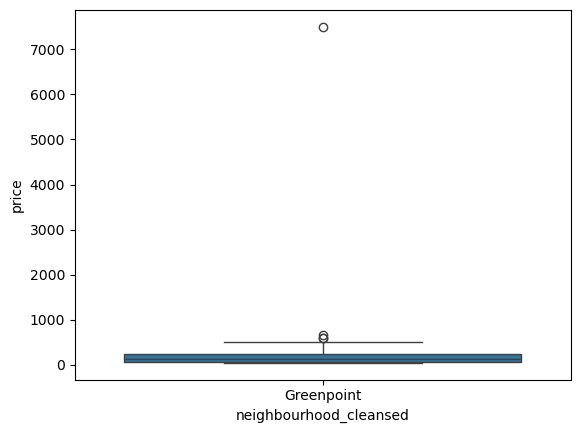

In [27]:
# Exploratory Data Analysis for each feature
sns.boxplot(
#    x="neighbourhood_cleansed", y="price", data=df_room_brooklyn_cleaned
    x="neighbourhood_cleansed", y="price", data=df_room_brooklyn_cleaned.query(
        "neighbourhood_cleansed == 'Greenpoint'"
    )
)
plt.show()